In [2]:
import numpy as np
import plotters as plot
import pandas as pd
import matplotlib.pyplot as plt
from darts import TimeSeries
from darts.utils.statistics import check_seasonality,plot_acf,plot_pacf,remove_seasonality,remove_trend,stationarity_test_adf
from darts.utils.statistics import extract_trend_and_seasonality


In [3]:
import os

list_data = os.listdir('./data')
csv_data = [n for n in list_data if n.endswith('.csv')]
for csv in sorted(csv_data):
    print(csv)


AEP_hourly.csv
COMED_hourly.csv
DAYTON_hourly.csv
DEOK_hourly.csv
DOM_hourly.csv
DUQ_hourly.csv
EKPC_hourly.csv
FE_hourly.csv
NI_hourly.csv
PJME_hourly.csv
PJMW_hourly.csv
PJM_Load_hourly.csv
pjm_hourly_est.csv


In [4]:
# def pre_analysis(path: str):
#     print(f"accessing {path}")
#     df1 = pd.read_csv(path, delimiter=',', nrows = 2000)    
#     df1.dataframeName = path
#     nRow, nCol = df1.shape
#     print(f'There are {nRow} rows and {nCol} columns')
#     print(df1.head())
#     plot.plot_per_column_distributions(df1, 2, 2);


# for data in csv_data:
#     data_path = './data/' + data
#     pre_analysis(data_path)

pjme_df.index 

In [5]:
pjme_df = pd.read_csv('./data/PJME_hourly.csv', delimiter=',', nrows = None)
pjme_df['Datetime'] = pd.to_datetime(pjme_df['Datetime'])
# pjme_df.set_index('Datetime', inplace=True)
pjme_df

,Datetime,PJME_MW
0,2002-12-31 01:00:00,26498.0
1,2002-12-31 02:00:00,25147.0
2,2002-12-31 03:00:00,24574.0
3,2002-12-31 04:00:00,24393.0
4,2002-12-31 05:00:00,24860.0
...,...,...
145361,2018-01-01 20:00:00,44284.0
145362,2018-01-01 21:00:00,43751.0
145363,2018-01-01 22:00:00,42402.0
145364,2018-01-01 23:00:00,40164.0


In [6]:
duplicate_dates = pjme_df['Datetime'][pjme_df['Datetime'].duplicated()]
print(f"Number of duplicate datetime entries: {len(duplicate_dates)}")
print("Sample of duplicate entries:")
print(duplicate_dates.head())
pjme_df = pjme_df.drop_duplicates(subset='Datetime', keep='last')

Number of duplicate datetime entries: 4
Sample of duplicate entries:
106585   2014-11-02 02:00:00
115369   2015-11-01 02:00:00
124009   2016-11-06 02:00:00
132817   2017-11-05 02:00:00
Name: Datetime, dtype: datetime64[ns]


In [7]:
pjme_df['PJME_MW'] = pjme_df['PJME_MW'].astype(np.float32)
pjme_sliced_df = pjme_df.loc[pjme_df['Datetime'] >= '2015-01-01']


/var/folders/bj/vqft4btx31x4b208qdl7q1nm0000gn/T/ipykernel_4939/1656443103.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pjme_df['PJME_MW'] = pjme_df['PJME_MW'].astype(np.float32)


/Users/matthewliew/.pyenv/versions/3.12.8/lib/python3.12/site-packages/darts/timeseries.py:5248: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  resampled_time_index = resampled_time_index.asfreq(freq)


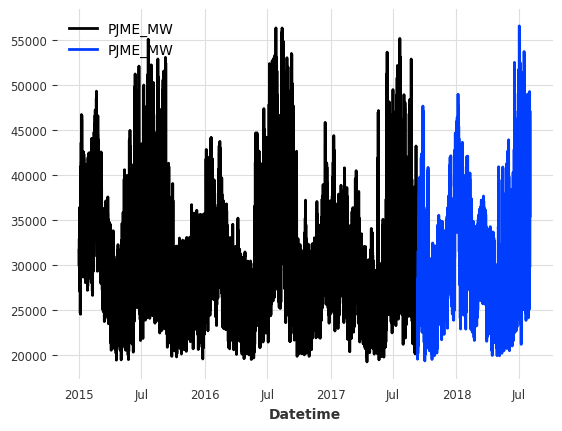

In [8]:
pjme_ts = TimeSeries.from_dataframe(pjme_sliced_df, 'Datetime', 'PJME_MW', freq='H')


train, test = pjme_ts.split_before(0.75)
train.plot()
test.plot()
n_pred = len(test)



In [9]:
train_df = train.to_dataframe()

train_df = train_df.sort_index()
train_df_interpolated = train_df.interpolate(method='time')
train_df_interpolated = train_df_interpolated.fillna(method='ffill').fillna(method='bfill')

train_df_interpolated

# train = TimeSeries.from_dataframe(train_df_interpolated, 'Datetime', 'PJME_MW', freq='H')


/var/folders/bj/vqft4btx31x4b208qdl7q1nm0000gn/T/ipykernel_4939/1428395336.py:5: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  train_df_interpolated = train_df_interpolated.fillna(method='ffill').fillna(method='bfill')


component,PJME_MW
Datetime,
2015-01-01 00:00:00,32802.0
2015-01-01 01:00:00,31647.0
2015-01-01 02:00:00,30755.0
2015-01-01 03:00:00,30189.0
2015-01-01 04:00:00,29890.0
...,...
2017-09-09 07:00:00,21640.0
2017-09-09 08:00:00,22570.0
2017-09-09 09:00:00,23949.0


In [10]:
check_seasonality(train)
# stationarity_test_adf(train)

(False, 0)

<Axes: xlabel='Datetime'>

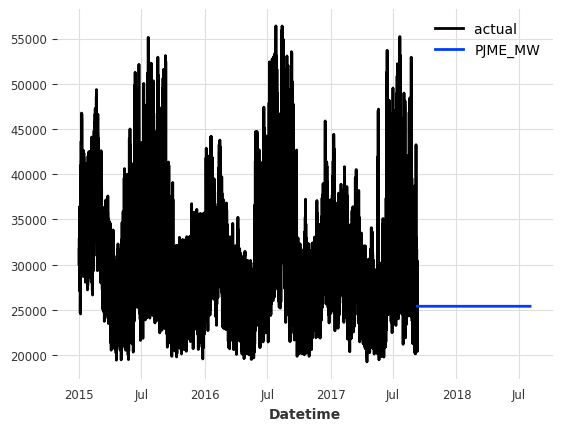

In [11]:
from darts.models.forecasting.sf_auto_arima import AutoARIMA

model = AutoARIMA()
model.fit(train)
forecast = model.predict(n_pred)
train.plot(label='actual ')
forecast.plot()


In [12]:
def compare(test: TimeSeries, forecast: TimeSeries) -> float: 
    diff = test - forecast
    diff.plot
    return np.mean(np.abs(diff))

/Users/matthewliew/.pyenv/versions/3.12.8/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<Axes: xlabel='Datetime'>

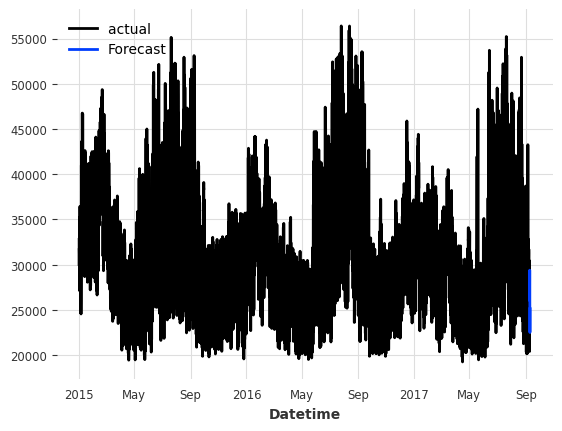

In [13]:
from darts.models import ARIMA

model = ARIMA(p=12, d=1, q=2)
model.fit(train)
pred = model.predict(n=24,series=train)
train.plot(label='actual ')
pred.plot(label='Forecast')

In [ ]:
pred_df = pred.to_dataframe()
test_df = test[:24].to_dataframe()
diff =pred_df['PJME_MW'] - test_df['PJME_MW']


# - test[:24]

In [32]:
test_df

component,PJME_MW
Datetime,
2017-09-09 12:00:00,25602.0
2017-09-09 13:00:00,25739.0
2017-09-09 14:00:00,25791.0
2017-09-09 15:00:00,25822.0
2017-09-09 16:00:00,25971.0
2017-09-09 17:00:00,26240.0
2017-09-09 18:00:00,26543.0
2017-09-09 19:00:00,26504.0
2017-09-09 20:00:00,26932.0


In [27]:
# from darts.models import NBEATSModel


# model = NBEATSModel(input_chunk_length=24,output_chunk_length=12,n_epochs=5,
#                     random_state = 0)
# model.fit(train)
# pred = model.predict(n=n_pred,series=train)
# train.plot(label='actual ')
# pred.plot(label='Forecast')




In [28]:
import pandas as pd
from darts import TimeSeries
from darts.models import ARIMA
from darts.dataprocessing.transformers import Scaler

# Assuming vic_elec_daily is your pandas DataFrame
# First, let's prepare the data

vic_elec_daily = TimeSeries.from_dataframe(pjme_sliced_df, 'Datetime', 'PJME_MW', freq='H')

# Convert DataFrame to Darts TimeSeries
series = TimeSeries.from_dataframe(vic_elec_daily, 'date', ['Demand', 'Temperature', 'Day_Type'])

# Create the squared temperature feature
vic_elec_daily['Temperature_squared'] = vic_elec_daily['Temperature'] ** 2

# Create the weekday feature
vic_elec_daily['Is_Weekday'] = (vic_elec_daily['Day_Type'] == 'Weekday').astype(int)

# Create covariates TimeSeries
covariates = TimeSeries.from_dataframe(vic_elec_daily, 'date', 
                                       ['Temperature', 'Temperature_squared', 'Is_Weekday'])

# Scale the series and covariates
scaler_target = Scaler()
scaler_covariates = Scaler()
series_scaled = scaler_target.fit_transform(series)
covariates_scaled = scaler_covariates.fit_transform(covariates)

# Create and fit the ARIMA model
model = ARIMA(p=1, d=1, q=1)  # You may need to adjust these parameters
fit = model.fit(series_scaled, future_covariates=covariates_scaled)


/Users/matthewliew/.pyenv/versions/3.12.8/lib/python3.12/site-packages/darts/timeseries.py:5248: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  resampled_time_index = resampled_time_index.asfreq(freq)


TypeError: Expected pandas-like dataframe, Polars dataframe, or Polars lazyframe, got: <class 'darts.timeseries.TimeSeries'>